# 프로젝트: 초해상화

## 루브릭 기준
1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.
  - SRGAN을 통해 생성된 이미지를 제출하였다.
2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본,  interpolation생성본을 비교분석하였다.
  - 이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.
3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.
  - 저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os

import tensorflow as tf

import imageio
from IPython.display import Image as show_gif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

In [ ]:
# folderpath = os.path.join(os.getenv("HOME"), 'aiffel/super_resolution')
# imgpath = os.path.join(folderpath, 'pieta.jpg')
imgpath = '/content/drive/MyDrive/Colab Notebooks/[LMS]/pieta.jpg'

img = cv2.imread(imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Displaying the image
# cv2.imshow('image', img)

- cv2.imshow시 이유 미상의 kerenel dead가 발생함

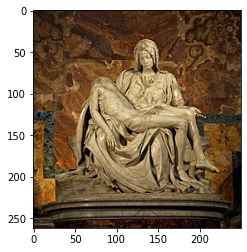

In [ ]:
plt.imshow(img)
# cv2.imshow('image', img)

In [ ]:
hr_image = img
hx, hy = hr_image.shape[1], hr_image.shape[0]

lr_image = cv2.resize(hr_image, dsize=(hx//4,hy//4)) # (가로 픽셀 수, 세로 픽셀 수)

In [ ]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5

--2021-09-14 06:54:56--  https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6578112 (6.3M) [application/x-hdf]
Saving to: ‘srgan_G.h5’

srgan_G.h5          100%[===================>]   6.27M  3.14MB/s    in 2.0s    

2021-09-14 06:54:58 (3.14 MB/s) - ‘srgan_G.h5’ saved [6578112/6578112]



In [ ]:
# model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/[LMS]/srgan_G.h5')

In [ ]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [ ]:
srgan_hr = apply_srgan(lr_image)

In [ ]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(hx, hy), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

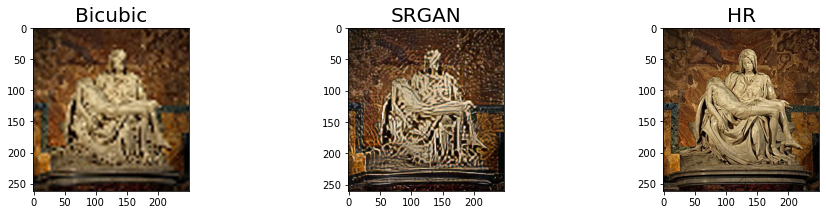

In [ ]:
images = [bicubic_image,srgan_hr,hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

- 이미지가 너무 작아 잘 알아볼 수 없으므로 특정 부분(얼굴)을 확대하여 보기로 하자.

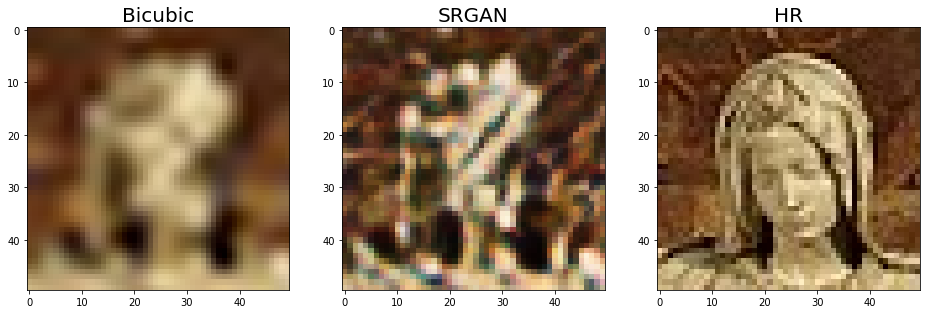

In [ ]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=50):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_top = (30, 110)

plt.figure(figsize=(16,10))

for i, (image, title) in enumerate(zip(images, titles), 1):
    plt.subplot(1,3,i)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

### [프로젝트 1-1 결론]
- LMS 클라우트 주피터의 문제로 인해 27kb짜리 데이터를 사용하였다.
- 원본 데이터의 크기가 작고 해상도도 낮아 그림을 x축 y축을 따라 각 4배씩 축소한 후 다시 4배씩 확대하였을 때 그림을 온전히 표현하기에 픽셀의 수가 너무 적었다. 또한 bicuic으로 interpolation했을 경우 흐릿하게 이상하였으나 SRGAN으로 해상도를 높였을 경우 선명하게 이상하게 되었다.
- 이렇게 보이는 이유는 linear interpolation으로는 흐린 이미지를 개선할 정보가 너무 적기 때문에 여전히 흐리게 나타나는 것이고, GAN의 경우 주변 이미지를 정보로 새로운 정보를 생산하기는 하지만 여전히 주변에 이 이미지를 확실히 단 하나의 이미지로 보이게 만들만큼의 정보가 없으므로 알 수 없는 이미지를 생성하고 있는 것으로 보인다.

# 프로젝트 1-2 

In [ ]:
# folderpath = os.path.join(os.getenv("HOME"), 'aiffel/super_resolution')
# imgpath = os.path.join(folderpath, 'pieta.jpg')
imgpath = '/content/drive/MyDrive/Colab Notebooks/[LMS]/pieta.jpg'

img = cv2.imread(imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Displaying the image
# cv2.imshow('image', img)

In [ ]:
srgan_img = apply_srgan(img)

In [ ]:
hr_image = img
hx, hy = hr_image.shape[1], hr_image.shape[0]

In [ ]:
bicubic_image = cv2.resize(
    img, 
    dsize=(hx*4, hy*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

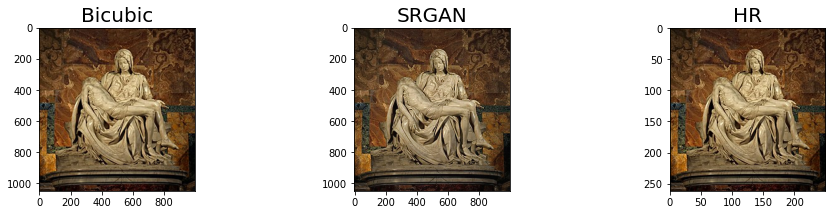

In [ ]:
images = [bicubic_image, srgan_img, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

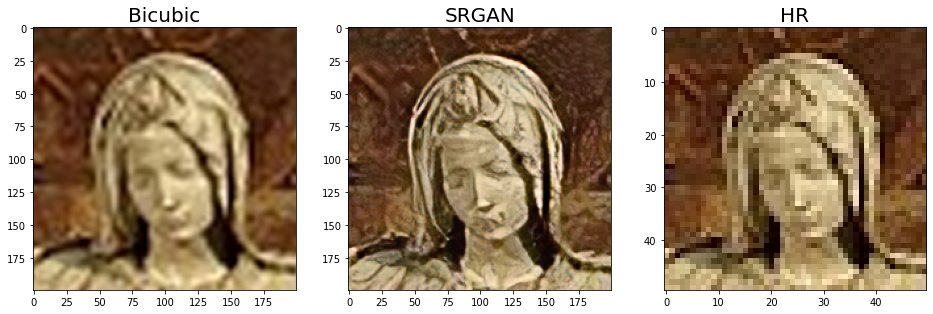

In [ ]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=50):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(30*4, 110*4)]*2+[(30, 110)]

plt.figure(figsize=(16,10))

for i, (image, left_top, title) in enumerate(zip(images, left_tops, titles), 1):
    plt.subplot(1,3,i)
    if title == 'HR':
        plt.imshow(crop(image, left_top))
    else :
        plt.imshow(crop(image, left_top, x = 200, y = 200))
    plt.title(title, fontsize=20)

### [프로젝트 1-2 결론]
- 4배로 키우면서 bicubic interpolation한 결과 시각적으로 보기에 이미지가 더 부드러워 졌음을 알 수 있다. 이는 원본 데이터를 그대로 둔 채 4배로 확대할 때는 원본 데이터에 이미지를 식별할 만큼의 정보량이 있었음을 알 수 있다. 또한 Bicubic한 이미지는 원본 데이터보다 더 부드러워졌음을 알 수 있는데, 이는 Linear하게 보간하므로 인해 생기는 자연스러운 결과이다. 이산형 그래프를 연속형으로 만들어 놓은 것과 같은 것이다.

- SRGAN은 따로 처리를 해주지 않아도 4배로 그림을 키우는 행동을 함을 알 수 있는데, 이는 아마 내부적으로 구현된 레이어 때문이라고 추측된다. SRGAN의 결과물은 얼핏 보기에 완전히 선명한 형태를 취하고 있는데, 마치 더 많은 찰흙을 덧대 그림을 메꿔놓은 것과 같다. 이는 주어진 정보로 주변 이미지를 생성하는 GAN 방식으로 인한 결과물인 것 같다.

# 프로젝트2

In [ ]:
!pip install imageio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


- [gifs](https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e)

In [ ]:
# 다운받은 파일의 경로를 설정해 주세요.
# gifpath = os.path.join(folderpath, 'fire_lr.gif')
gif = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/[LMS]/fire_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


In [ ]:
# frames_sr = dict({'bi':[], 'gan':[]})
frames_sr_bi = []
frames_sr_gan = []
for frame in frames:
    fx, fy = frame.shape[1], frame.shape[0]
    #Bicubic
    bicubic_image = cv2.resize(
        frame, 
        dsize=(fx*4, fy*4), # (가로 픽셀 수, 세로 픽셀 수)
        interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
    )
    frames_sr_bi.append(bicubic_image)

In [ ]:
print(len(frames_sr_bi))

14


In [ ]:
for _, frame in enumerate(frames): 
    #[Trouble] 가로, 세로 픽셀수를 4배로 키울 경우 OOM 오류가 남
    # fx, fy = frame.shape[1], frame.shape[0]
    # lr_image = cv2.resize(frame, dsize=(fx*4,fy*4)) # (가로 픽셀 수, 세로 픽셀 수)
    #SRGAN
    srgan_img = apply_srgan(frame)
    frames_sr_gan.append(srgan_img)

In [ ]:
imageio.mimsave("high_bi.gif", frames_sr_bi)
imageio.mimsave("high_gan.gif", frames_sr_gan)

In [ ]:
!ls

drive  high_bi.gif  high_gan.gif  sample_data  srgan_G.h5


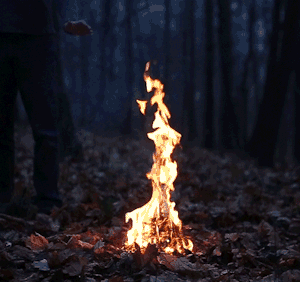

In [37]:
show_gif(open("/content/drive/MyDrive/Colab Notebooks/[LMS]/fire_lr.gif",'rb').read(), width=400)

In [38]:
show_gif(open("/content/drive/MyDrive/Colab Notebooks/[LMS]/high_bi.gif",'rb').read(), width=400)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
show_gif(open("/content/drive/MyDrive/Colab Notebooks/[LMS]/high_gan.gif",'rb').read(), width=400)

Output hidden; open in https://colab.research.google.com to view.

- SRGAN으로 만든 모닥불을 보면 다크소울3의 리마스터링 버전 같아보인다. 이런 그래픽으로 나와주면 좋을텐데.

# 회고
 - 해당 노드는 srgan을 활용한 초해상화Super Resolution에 대한 노드였다.
 - 노드의 진행내용은 단순하였다.
 - 그러나 학습된 모델을 가져다 새로운 이미지에 적용한다는 아이디어는 굉장히 신선하게 다가왔으며, 이렇게 여러가지 모델을 가져다 쓸 수 있는 능력을 개발하는 것도 데이터 분석을 하고자 하는 사람의 능력중 큰 부분을 차지한다고 생각한다.
 - 그렇다면 아주 기초적인 내용을 토대로 모델을 이해하고, 그 모델을 구현하고, 구현된 모델을 가져다 사용하고, 비즈니스적인 결과를 도출하는 전반적인 과정이 데이터 과학자의 역량을 결정한다고 할 수 있을 것이다.
 - 그러나 아직은 맛만 본다는 느낌이 너무 강하다. 시간을 많이 투자하고 있다고는 하나 여전히 부족함을 느낀다. 더 가벼운 마음으로 더 많은 내용을 봐야겠다고 다짐한다.